##  Moseli Motsoehli

### Seq to Seq model for comparing text similarity.

__I use the quora question pairs dataset as a test for this although the model is eventually used for text transcribed from recorded speech as a way to evaluate  public speaking__

I reuse mose of my code from a combination of a text summarization project with Jan Platos and preprocessing from a topic modelling project for ICS661. 

In [1]:
#### Libraries
import scipy as sc
from scipy.spatial.distance import cosine
import pandas as pd
import math
import logging
from collections import Counter
from  tqdm import tqdm
from tabulate import tabulate
from Generator import *

from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split as tts
from sklearn.preprocessing import LabelBinarizer

import os
import re
import nltk
from nltk.tokenize import word_tokenize as wt
from nltk.tokenize import sent_tokenize as st
from nltk.corpus import stopwords
nltk.download('stopwords')

import matplotlib.pyplot as plt

import keras
from keras.preprocessing.sequence import pad_sequences
from keras import backend as k
from keras import initializers
from keras.optimizers import RMSprop,Adam,Adagrad
from keras.models import Model,Sequential
from keras.layers import Dense,LSTM,Input,Activation,Flatten,concatenate,Reshape,Embedding,Bidirectional,Dropout
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from keras.utils import to_categorical
from keras.callbacks import LearningRateScheduler,EarlyStopping

#model Freezing
import tensorflow as tf
# freeze_graph "screenshots" the graph
from tensorflow.python.tools import freeze_graph
# optimize_for_inference lib optimizes this frozen graph
from tensorflow.python.tools import optimize_for_inference

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/moselim/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Using TensorFlow backend.


## Constants

In [2]:
STRING_SIZE=16
BATCH_SIZE=16
NUM_EPOCHS = 25

## Load Dataset

In [3]:
datafile = "train.csv"

data =  pd.read_csv(datafile,sep=",")[:][:-1]
print("Number of examples: %s"%len(data))
data=data.dropna(subset=['question1','question2', 'is_duplicate'])
data=data.reset_index(drop=True)
print("Number of examples after removing NA: %s"%len(data))
print("\n")
print(data.head(2))
print("\n")
print(data.tail(2))
print("\n")
print("propotion of positives: %s"%np.mean(data["is_duplicate"]))

Number of examples: 404289
Number of examples after removing NA: 404286


   id  qid1  qid2                                          question1  \
0   0     1     2  What is the step by step guide to invest in sh...   
1   1     3     4  What is the story of Kohinoor (Koh-i-Noor) Dia...   

                                           question2  is_duplicate  
0  What is the step by step guide to invest in sh...             0  
1  What would happen if the Indian government sto...             0  


            id    qid1    qid2  \
404284  404287  537928  537929   
404285  404288  537930  537931   

                                                question1  \
404284                                  What is one coin?   
404285  What is the approx annual cost of living while...   

                                                question2  is_duplicate  
404284                                  What's this coin?             0  
404285  I am having little hairfall problem but I want...        

### Preprocessing addopted from my Topic Model in ICS661 AKA Thematron

In [4]:
def remove_special(text):
    special_chars = "[~#$%^@&*&()+-_\",?!.:[]\\;><`|{}=\\'=»¿シし]"
    for k in special_chars:
            if type(text) == str:
                if k=="-" or k=="_":
                    text=text.replace(k, "")
                else:
                    text=text.replace(k, " ")       
    return text

def contractions(sent):
    sub_pattern = [("will not","won't"),("shall not","shan't"),
                (" not", "n\'t"),(" will","\'ll"),(" is","\'s"),
                   (" am","\'m"),(" are","\'re"),(" is","who\'s")]
    sent2=sent.split(" ")
    hold = ""
    for k in range(len(sent2)):
        kk = sent2[k]
        for rep in range(len(sub_pattern)):
            kk = re.sub(sub_pattern[rep][1],sub_pattern[rep][0],kk)
        hold = hold + " " + kk
    return hold.lower()

def remove_stop_words(text):
    stops =  set(stopwords.words('english'))
    stops1 = [word.lower() for word in stops]
    punctuation = [',','.','!','?',';','-']
    hold = []
    if type(text) == list:
        for word in range(len(text)):
            if text[word].lower() in stops1 or text[word].lower() in punctuation or text[word].lower() == "xxxxxx":
                continue
            else:
                hold.append(text[word].lower())
    return hold

def wordTok(sent):
    tok = wt(sent)
    return tok

def pipeline(text):
    text = contractions(text)
    text = remove_special(text)
    textToks = wordTok(text)
    #textToks = remove_stop_words(textToks)
    final = ""
    for k in range(len(textToks)):
            final = final+textToks[k]+" "
    return final.strip().lower()

########################################################
########create corpus and create word vectors and training data###########
def createCorpus(t):
    corpus = []
    all_sent = []
    for k in t:
        for p in t[k]:
            corpus.append(st(p))
    for sent in range(len(corpus)):
        for k in corpus[sent]:
            all_sent.append(k)
    for m in range(len(all_sent)):
        all_sent[m] = wt(all_sent[m])
    
    all_words=[]
    for sent in all_sent:
        hold=[]
        for word in sent:
            hold.append(word.lower())
        all_words.append(hold)
    return all_words

def wordvecmatrix(model1,data):
    IO_data={"question1":[],"question2":[],"label":[]}
    pbar = tqdm(range(len(data["question1"])))
    for k in range(len(data["question1"])):
        q1=[]
        q2=[]
        label=[]
        for word in data["question1"][k]:
            try:
                q1.append(model1.wv.word_vec(word))
            except Exception as e:
                continue
        for word in data["question2"][k]:
            try:
                q2.append(model1.wv.word_vec(word))
            except Exception as e:
                continue
        IO_data["label"].append(data["is_duplicate"][k])
        IO_data["question1"].append(q1) 
        IO_data["question2"].append(q2)
        pbar.update(1)
    print('\007')
    pbar.close()
    return IO_data

def sequence_padding(stringlist):
    newstring = pad_sequences(stringlist, maxlen=STRING_SIZE,
                              dtype=object,padding='post',
                              truncating='post', value="PAD")
    return newstring

def list2string(listinput):
    hold=""
    for k in listinput:
        hold = hold +k.strip()+" "
    return hold.strip()

In [5]:
data["question1"] = list(map(pipeline,data["question1"]))
data["question2"] = list(map(pipeline,data["question2"]))


print("Show two comparison sentences")
print("--------------------------------------------")
print("1: ",data["question1"][1])
print("--------------------------------------------")
print("2: ",data["question2"][1])
print("--------------------------------------------")
print(data["is_duplicate"][1])

Show two comparison sentences
--------------------------------------------
1:  what is the story of kohinoor kohinoor diamond
--------------------------------------------
2:  what would happen if the indian government stole the kohinoor kohinoor diamond back
--------------------------------------------
0


### Corpus and Wordvectors

In [6]:
sentences1 = list(map(wordTok,data["question1"]))
sentences2 = list(map(wordTok,data["question2"]))

####Truncade and Pad to N words max
sentences1 = list(map(list,sequence_padding(sentences1)))
sentences2 = list(map(list,sequence_padding(sentences2)))

data["question1"] = sentences1
data["question2"] = sentences2
dataAll = [data["question1"],data["question2"]] 
dataAll = pd.concat(dataAll)

model1 = Word2Vec(size = 200,sg=1,compute_loss=False,window=3,
                 min_count=1,workers=8)
model1.build_vocab(dataAll)  # prepare the model vocabulary
model1.train(dataAll, total_examples=model1.corpus_count,queue_factor=5, epochs=10)

final_data = wordvecmatrix(model1,data)
print(sentences1[2])
print(len(final_data["question1"][2]))
print(sentences2[2])
print(len(final_data["question2"][2]))
del dataAll

100%|██████████| 404286/404286 [00:29<00:00, 13835.07it/s]


['how', 'can', 'i', 'increase', 'the', 'speed', 'of', 'my', 'internet', 'connection', 'while', 'using', 'a', 'vpn', 'PAD', 'PAD']
16
['how', 'can', 'internet', 'speed', 'be', 'increased', 'by', 'hacking', 'through', 'dns', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD']
16


In [7]:
print(pd.DataFrame(final_data).head(5))
cosine(model1.wv.word_vec("increase"),model1.wv.word_vec("increased"))

                                           question1  \
0  [[-0.30817324, 0.0052596773, -0.043622255, -0....   
1  [[-0.30817324, 0.0052596773, -0.043622255, -0....   
2  [[-0.09129786, 0.5827426, 0.36310938, -0.44661...   
3  [[-0.035074685, 0.062375914, 0.036061313, -0.1...   
4  [[-0.2977956, -0.0685954, 0.136026, -0.8348036...   

                                           question2  label  
0  [[-0.30817324, 0.0052596773, -0.043622255, -0....      0  
1  [[-0.30817324, 0.0052596773, -0.043622255, -0....      0  
2  [[-0.09129786, 0.5827426, 0.36310938, -0.44661...      0  
3  [[-0.005785195, 0.21426494, 0.56165993, 0.3640...      0  
4  [[-0.2977956, -0.0685954, 0.136026, -0.8348036...      0  


0.4388538599014282

In [8]:
split=int(0.8*len(final_data["label"]))
#x_train,x_test,y_train,y_test = tts(sentall,y,test_size=0.2)
#x_train,x_val,y_train,y_val = tts(x_train,y_train,test_size=0.1)
#y = to_categorical(data["is_duplicate"])
y=final_data["label"]
x1_train = np.asarray(final_data["question1"][:split],dtype='float32')
x1_val = np.asarray(final_data["question1"][split:],dtype='float32')
x2_train = np.asarray(final_data["question2"][:split],dtype='float32')
x2_val = np.asarray(final_data["question2"][split:],dtype='float32')
y_train = np.asarray(y[:split],dtype='float32')
y_val = np.asarray(y[split:],dtype='float32')

TRAIN_SIZE = len(x1_train)
VAL_SIZE = len(x1_val)

gentrain = get_samples_2_inputs(x1_train,x2_train,y_train,batch_size=BATCH_SIZE)
gentest = get_samples_2_inputs(x1_val,x2_val,y_val,BATCH_SIZE)

In [10]:
print(x1_train.shape)
print(y_train.shape)

(323428, 16, 200)
(323428,)


Results of the embedding are returned as a list of sentences and their token embeddings, so each sentence is of the form<br>
__(sentence,embeddings for each word)__

### Now Build an LSTM model with 2 inputs and one output

In [11]:
def step_decay(epoch):
	initial_lrate = 0.001
	drop = 0.5
	epochs_drop = 3
	lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
	return lrate

In [12]:
model1_input = Input(shape=(x1_train.shape[1],x1_train.shape[2]),name="input1")
model1_LSTM = LSTM(128,return_sequences=False,activation='relu',
                   dropout=0.4,recurrent_dropout=0.2,name="LSTM1")(model1_input)
model1 = Model(model1_input,model1_LSTM)

model2_input = Input(shape=(x2_train.shape[1],x2_train.shape[2]),name='input2')
model2_LSTM = LSTM(128,return_sequences=False,activation='relu',
                   dropout=0.4,recurrent_dropout=0.2,name="LSTM2")(model2_input)
model2 = Model(model2_input,model2_LSTM)

merged = concatenate([model1_LSTM,model2_LSTM],name="merge")
#model_merged_LSTM = LSTM(64,return_sequences=False,activation='relu',dropout=0.4,recurrent_dropout=0.1,name="LSTM_merge")(merged)
Dense_merged1 = Dense(128,activation="relu",name="dense1")(merged)
dropout_merged =  Dropout(0.4)(Dense_merged1)
Dense_merged2 = Dense(64,activation="relu",name="dense2")(dropout_merged)
model_merged_out = Dense(1,activation="sigmoid",name="output")(Dense_merged2)
model=Model([model1_input,model2_input],model_merged_out)

adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.998)
model.compile(adam, loss ='binary_crossentropy', metrics=['accuracy'])

lrate = LearningRateScheduler(step_decay)
earlystopper = EarlyStopping(monitor='val_loss', patience=10, verbose=1,restore_best_weights=True)
callbacks_list = [lrate,earlystopper]
model.fit([x1_train[:400],x2_train[:400]], y_train[:400],
          epochs=1,
          verbose=1,
          batch_size=16,
          validation_split=0.15,
          callbacks=callbacks_list)
model.summary()

W1121 22:17:09.850288 47900446662336 deprecation_wrapper.py:119] From /home/moselim/.conda/envs/tensorflow/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:541: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1121 22:17:09.870119 47900446662336 deprecation_wrapper.py:119] From /home/moselim/.conda/envs/tensorflow/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:66: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1121 22:17:09.871195 47900446662336 deprecation_wrapper.py:119] From /home/moselim/.conda/envs/tensorflow/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4432: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W1121 22:17:09.988560 47900446662336 deprecation_wrapper.py:119] From /home/moselim/.conda/envs/tensorflow/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:148: The name tf.placeholder_with_defa

Train on 340 samples, validate on 60 samples
Epoch 1/1
340/340 [==============================] - 5s 15ms/step - loss: 0.6830 - acc: 0.6029 - val_loss: 0.6572 - val_acc: 0.6667
Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input1 (InputLayer)             (None, 16, 200)      0                                            
__________________________________________________________________________________________________
input2 (InputLayer)             (None, 16, 200)      0                                            
__________________________________________________________________________________________________
LSTM1 (LSTM)                    (None, 128)          168448      input1[0][0]                     
__________________________________________________________________________________________________
LSTM2 (LSTM)  

In [ ]:
model.fit_generator(gentrain, 
                     steps_per_epoch=TRAIN_SIZE//BATCH_SIZE,
                     verbose=1,
                     validation_data=gentest,
                     validation_steps=VAL_SIZE//BATCH_SIZE,
                     epochs=NUM_EPOCHS,
                     workers=8,
                     use_multiprocessing=False,
                     callbacks=callbacks_list)
model.save('my_model_lstm256_word2vec.h5')

Epoch 1/25
20214/20214 [==============================] - 827s 41ms/step - loss: 0.5461 - acc: 0.7272 - val_loss: 0.5093 - val_acc: 0.7503
Epoch 2/25
20214/20214 [==============================] - 817s 40ms/step - loss: 0.5255 - acc: 0.7455 - val_loss: 0.5503 - val_acc: 0.7582
Epoch 3/25
20214/20214 [==============================] - 815s 40ms/step - loss: 0.5137 - acc: 0.7534 - val_loss: 0.4836 - val_acc: 0.7622
Epoch 4/25
20214/20214 [==============================] - 816s 40ms/step - loss: 0.5059 - acc: 0.7565 - val_loss: 0.4798 - val_acc: 0.7655
Epoch 5/25
20214/20214 [==============================] - 816s 40ms/step - loss: 0.5081 - acc: 0.7573 - val_loss: 0.4801 - val_acc: 0.7686
Epoch 6/25
20214/20214 [==============================] - 819s 41ms/step - loss: 0.5093 - acc: 0.7600 - val_loss: 0.4760 - val_acc: 0.7689
Epoch 7/25
20214/20214 [==============================] - 819s 41ms/step - loss: 0.5111 - acc: 0.7617 - val_loss: 0.4745 - val_acc: 0.7694
Epoch 8/25
20214/20214 [===

In [16]:
model.evaluate([x1_val,x2_val],y=y_val,
              batch_size=BATCH_SIZE)

80858/80858 [==============================] - 75s 922us/step


[0.6535393419869976, 0.6402705978381854]

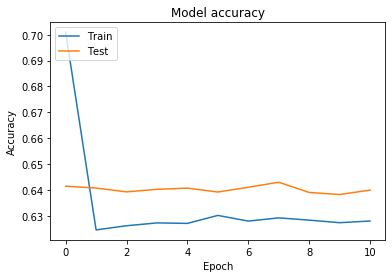

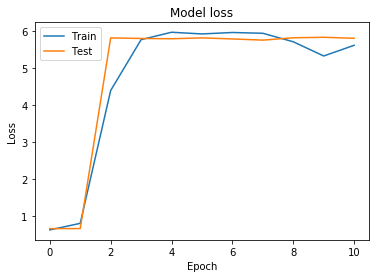

In [17]:
plt.plot(model.history.history['acc'])
plt.plot(model.history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()